Linear regression models are relatively straightforward to interpret; you can derive useful insights by discovering the relationships in the data. But the story does not end there. Using past observations, you can create an estimated model to predict unknown observations.

In this lesson, you'll learn about the following:

* How to make predictions using estimated linear regression models
* How to evaluate the predictive performance of regression models

Throughout the lesson, you'll see how to make predictions by splitting your data into training and test sets. You'll estimate your models using only the training set. As a result, your models will not see the observations in the test set, and the information in the test observations will not be used in the estimation of the models. By holding out a portion of the data and testing on it, you can evaluate the results of your models as if they were performing on unseen real-world observations.

## Making predictions using linear regression models

You'll start by exploring how to make predictions on the medical cost dataset from an insurance company. First, you need to load the dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine, text

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'medicalcosts'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

insurance_df = pd.read_sql_query(text('SELECT * FROM medicalcosts'), con=engine.connect())

# No need for an open connection, because you're only doing a single query
engine.dispose()

You'll focus on several features in this dataset: age, sex, BMI, number of children, and whether the person is a smoker. With these features, you can use a linear regression model to predict the cost of a person's medical expenses. This could be very useful information for an insurance company; they could use this model to accurately predict a person's potential medical costs and then adjust their premiums accordingly.

In [3]:
insurance_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.900
1,18,male,33.770,1,no,southeast,1725.550
2,28,male,33.000,3,no,southeast,4449.460
3,33,male,22.705,0,no,northwest,21984.500
4,32,male,28.880,0,no,northwest,3866.860
5,31,female,25.740,0,no,southeast,3756.620
6,46,female,33.440,1,no,southeast,8240.590
7,37,female,27.740,3,no,northwest,7281.510
8,37,male,29.830,2,no,northeast,6406.410
9,60,female,25.840,0,no,northwest,28923.100


Computers love numbers but not text. So turn the `sex` and `smoker` columns into binary columns, but only keep the column that is `True`.

In [4]:
insurance_df["is_male"] = pd.get_dummies(insurance_df.sex, drop_first=True)
insurance_df["is_smoker"] = pd.get_dummies(insurance_df.smoker, drop_first=True)

In [5]:
# `Y` is the target variable (what you are trying to predict)
Y = insurance_df['charges']

# `X` is the feature set that you are using to predict the medical costs
X = insurance_df[['is_male','is_smoker', 'age', 'bmi','children']]

Now, split your data into training and test sets. You'll be using scikit-learn's `train_test_split()` method to do this. This method takes several inputs: the features, the target, the test size, and random state parameters. The `train_test_split()` method uses the `test_size` parameter to decide how much of the data will be split out as test data. Below, the `test_size` parameter is set to `0.2`, which means that you'll use 20% of the data as the test set.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1070
The number of observations in test set is 268


Now, the features in the training and test sets are assigned to `X_train` and `X_test`, respectively. Similarly, the targets are assigned to `y_train` and `y_test`. Next, you'll use one of the previous models—but this time, you'll train it using only the training set.

Later on, you'll predict on `X_test` and use different evaluation metrics to see how close the predictions are to `y_test`.

In [7]:
X_train.head()

,is_male,is_smoker,age,bmi,children
172,1,0,18,15.960,0
814,1,0,36,34.430,2
553,0,0,52,31.730,2
1239,0,0,25,42.130,1
697,1,1,41,35.750,1


Now, add a constant to the model. This will serve as the "baseline" of the data in case all of your features' values are `0`.

In [8]:
X_train = sm.add_constant(X_train)

Now, train the model!

In [9]:
# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     629.9
Date:                Mon, 13 Nov 2023   Prob (F-statistic):          6.39e-315
Time:                        03:20:25   Log-Likelihood:                -10848.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1064   BIC:                         2.174e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.206e+04   1080.784    -11.161      0.0

As you can see from the summary table, each feature is a coefficient. And each feature either increases or decreases the overall medical costs. The information given will be used as an equation for predictions.

It's time to get the predictions! In statsmodels, you make predictions by calling the `predict()` function as follows:

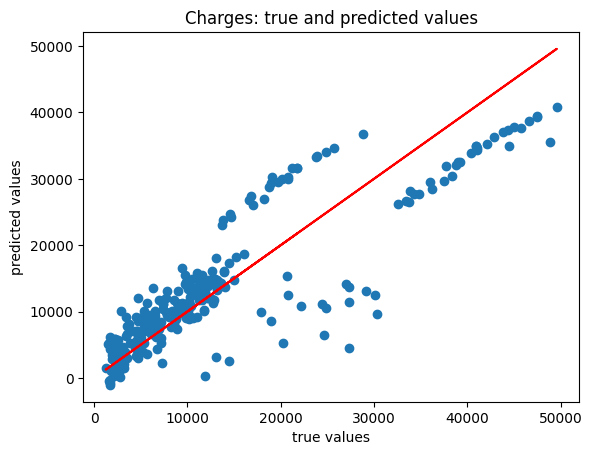

Mean absolute error of the prediction is: 4158.061597698162
Mean squared error of the prediction is: 33814649.37955361
Root mean squared error of the prediction is: 5815.036489958908
Mean absolute percentage error of the prediction is: 42.38515196906039


In [10]:
# Add a constant to the model because it's best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# You are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



In the above graph, you can see that your model predicts the lower values of the target better than it predicts the higher values. By using visualizations like this, you can more intuitively understand the performance of the models. But you need to find more accurate ways of assessing your models. Above, there are some metrics that you can use to evaluate how good the predictions are. You'll explore those metrics next.

## Evaluation metrics

When you were evaluating the training performance of a linear regression model, you used metrics like R-squared and adjusted R-squared. R-squared measures the ratio of variance in the target variable that is explained by the model. But when you are making predictions, you care more about how close your predictions are to the target rather than the variance in the target variable. This means that you'll usually use metrics other than R-squared to gauge how good your predictions are. Here, you'll learn about four of the most common ones.

| Metric | Definition | Equation |
| :-- | :-- | :-- |
| Mean absolute error (MAE) | The average of the absolute values of the errors between the true values and the predicted values | $$ \frac{1}{n} \sum_{i=1}^{n}\lvert y_i-\hat{y}_i\rvert $$|
| Mean squared error (MSE) | The average of the squared errors between the true values and the predicted values | $$ \frac{1}{n} \sum_{i=1}^{n} (y_i-\hat{y}_i)^2  $$ |
| Root mean squared error (RMSE) | The square root of the MSE | $$ \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i-\hat{y}_i)^2}  $$ |
| Mean absolute percentage error (MAPE) | The average of the ratio of the absolute values of the errors to the true values | $$ \frac{1}{n} \sum_{i=1}^{n}\frac{\lvert y_i-\hat{y}_i\rvert}{y_i}  $$ |

Although these are different metrics, they are essentially using the difference between what you know to be the correct medical cost for a person and the predicted medical cost from the model. These errors are then summed up for an overall error score.

You can use any one of the above metrics. But there are some important points to note about them:

* Lower values are desirable for all four metrics. The lower the value, the better the performance of the model.
* MAE, MSE, and RMSE are in the unit of the target variable, but MAPE is unitless. So MAE, MSE, and RMSE are only useful if you compare different models that have the same target variable.
* MSE and RMSE penalize large errors more than the MAE and MAPE do. This means that MSE and RMSE are more useful when high error values are undesirable.
* For target values very close to zero, MAPE may provide a problematic picture of the performance because the ratio may go to very high values, and this may distort the average. It can also give divide-by-zero errors if some values of the target are zero.


## Improving on the previous model

To compare with the model above, use another model where the interaction of `BMI` and `is_smoker` is included.

In [11]:
# `Y` is the target variable (what you are trying to predict)
Y = insurance_df['charges']

# This is the interaction between BMI and smoking
insurance_df["bmi_is_smoker"] = insurance_df.bmi * insurance_df.is_smoker

# `X` is the feature set
X = insurance_df[['is_male','is_smoker', 'age', 'bmi', "bmi_is_smoker"]]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in the training set is {}".format(X_train.shape[0]))
print("The number of observations in the test set is {}".format(X_test.shape[0]))

# Add a constant to the model because it's best practice
# to do so every time!
X_train = sm.add_constant(X_train)

# Fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# Print the summary results
print(results.summary())

The number of observations in the training set is 1070
The number of observations in the test set is 268
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     1052.
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        03:20:25   Log-Likelihood:                -10631.
No. Observations:                1070   AIC:                         2.127e+04
Df Residuals:                    1064   BIC:                         2.130e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

This second model's R-squared is `0.832`. That's higher than the previous model, where the R-squared was `0.745`. This means that the second model's goodness of fit is higher than the previous one. Now, make predictions using this model:

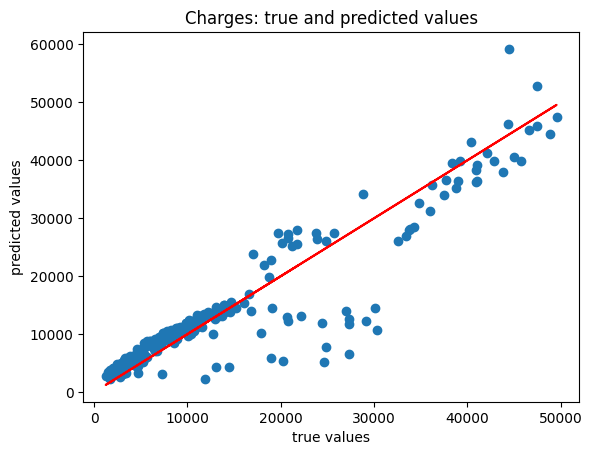

Mean absolute error of the prediction is: 2749.4722864791815
Mean squared error of the prediction is: 19957476.99035299
Root mean squared error of the prediction is: 4467.379208255438
Mean absolute percentage error of the prediction is: 29.237052069764225


In [12]:
# Add a constant to the model because it's best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# You are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

The test set performance of the second model is better than the previous one with respect to all four of these metrics! Compared to the previous model, this second model seems to better predict high values of the target variable. It also seems that the second model better predicts low values because the points are more tightly clustered around the red line.